# Comparing hourly and 6-hourly data from the NOAA GDP

This notebook consists of a comparison of data contained in the [hourly](https://www.aoml.noaa.gov/phod/gdp/hourly_data.php) and [6-hourly](https://www.aoml.noaa.gov/phod/gdp/interpolated/data/all.php) drifter datasets from the [NOAA GDP](https://www.aoml.noaa.gov/phod/gdp/index.php). The notebook eventually creates the figure which can be found on the webpage for the hourly dataset.

In [1]:
# general library import
import numpy as np

# clouddrift imports
from clouddrift import datasets
from clouddrift.ragged import subset

# plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean

For this example we are going to plot side-by-side the trajectories of drifter `id` 2578 colored by SST, as the data appeared either in the hourly or 6-hourly datasets.

In [2]:
# chose drifter `id`` 2578 and select some plot parameters
selected_id = 2578

lon = [-53.6, -52.4]
lat = [44.7, 45.2]

# open the two datasets and subset them for the selected id. Here the `subset`` function requires to indicate the row dimension name which is "traj" for the 6h and 1h datasets 
# (the default expected is "rows" otherwise)
ds_6h = subset(datasets.gdp6h(), {"id": selected_id}, row_dim_name="traj").load()
ds_1h = subset(datasets.gdp1h(), {"id": selected_id}, row_dim_name="traj").load()

# further subset the data for the subregion and put them in a list for plotting
ds = []
for d in [ds_6h, ds_1h]:
    ds.append(subset(d, {"lon": (lon[0], lon[1]), "lat": (lat[0], lat[1])}, row_dim_name="traj"))


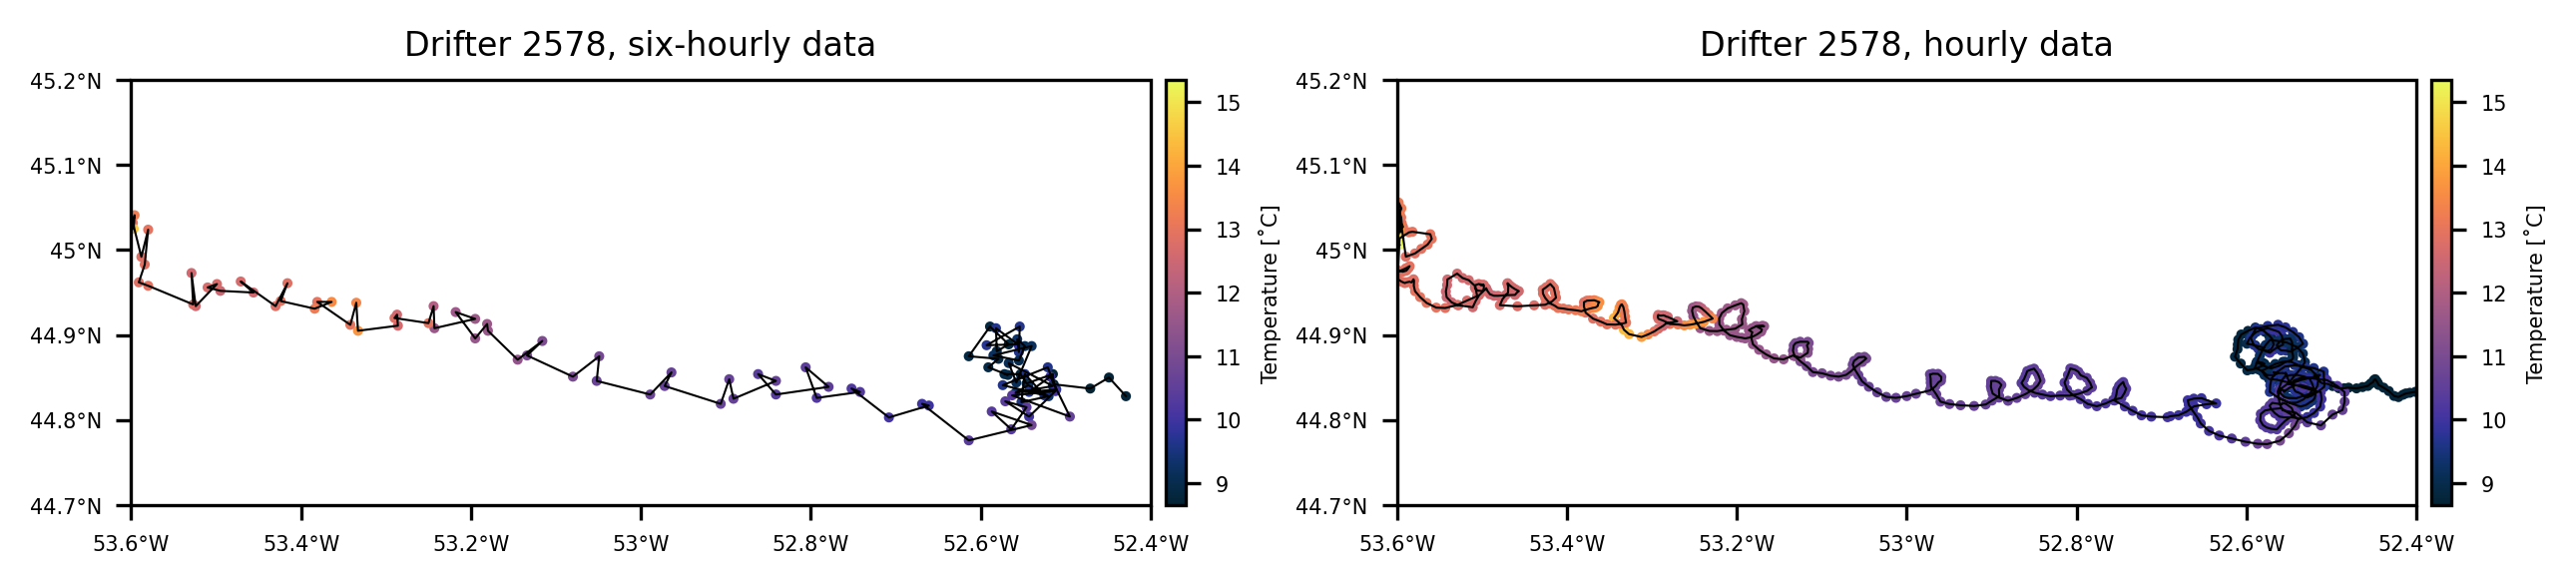

In [3]:
# make the figure
title = ["six-hourly", "hourly"]
ticks = [0.2, 0.1]

plot_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 3), dpi=300)
ax1 = fig.add_subplot(1, 2, 1, projection=plot_crs)
ax2 = fig.add_subplot(1, 2, 2, projection=plot_crs)

# colorbar limits
vmin = min(ds[0].temp.min(), ds[1].sst.min() - 273.15)
vmax = max(ds[0].temp.max(), ds[1].sst.max() - 273.15)

for i, ax in enumerate([ax1, ax2]):
    ax.set_title(f"Drifter {selected_id}, {title[i]} data", fontsize=8)
    ax.plot(ds[i].lon, ds[i].lat, color="k", linewidth=0.5, transform=plot_crs)

    # colorbar axis
    divider1 = make_axes_locatable(ax)
    cax = divider1.append_axes("right", size="2%", pad=0.05, axes_class=plt.Axes)

    s = ax.scatter(
        ds[i].lon,
        ds[i].lat,
        c=ds[i].temp if i == 0 else ds[i].sst - 273.15,
        s=2,
        transform=plot_crs,
        vmin=vmin,
        vmax=vmax,
        cmap=cmocean.cm.thermal,
    )
    cb = fig.colorbar(s, cax=cax)
    cb.ax.tick_params(labelsize=5)
    cb.set_label("Temperature [˚C]", fontsize=5)

    ax.set_xticks(np.arange(lon[0], lon[1] + ticks[0], ticks[0]), crs=plot_crs)
    ax.set_yticks(np.arange(lat[0], lat[1] + ticks[1], ticks[1]), crs=plot_crs)
    ax.tick_params(axis="x", labelsize=5)
    ax.tick_params(axis="y", labelsize=5)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.set_xlim(lon)
    ax.set_ylim(lat)

# fig.savefig("gdp-hourly.png", format="png", bbox_inches="tight", dpi=300)